In [1]:
#Importing libraries for initial exploratory analysis

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mlt
%matplotlib inline

#For Feature Engineering:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

#For Predictive Modeling
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import *
from sklearn.model_selection import GridSearchCV

#For Model Evaluation
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score,f1_score,classification_report,recall_score
from sklearn.preprocessing import label_binarize

In [2]:
## Loading the data
datafile = "heart.csv"
df = pd.read_csv(datafile, sep=',')
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


# Exploratory analysis

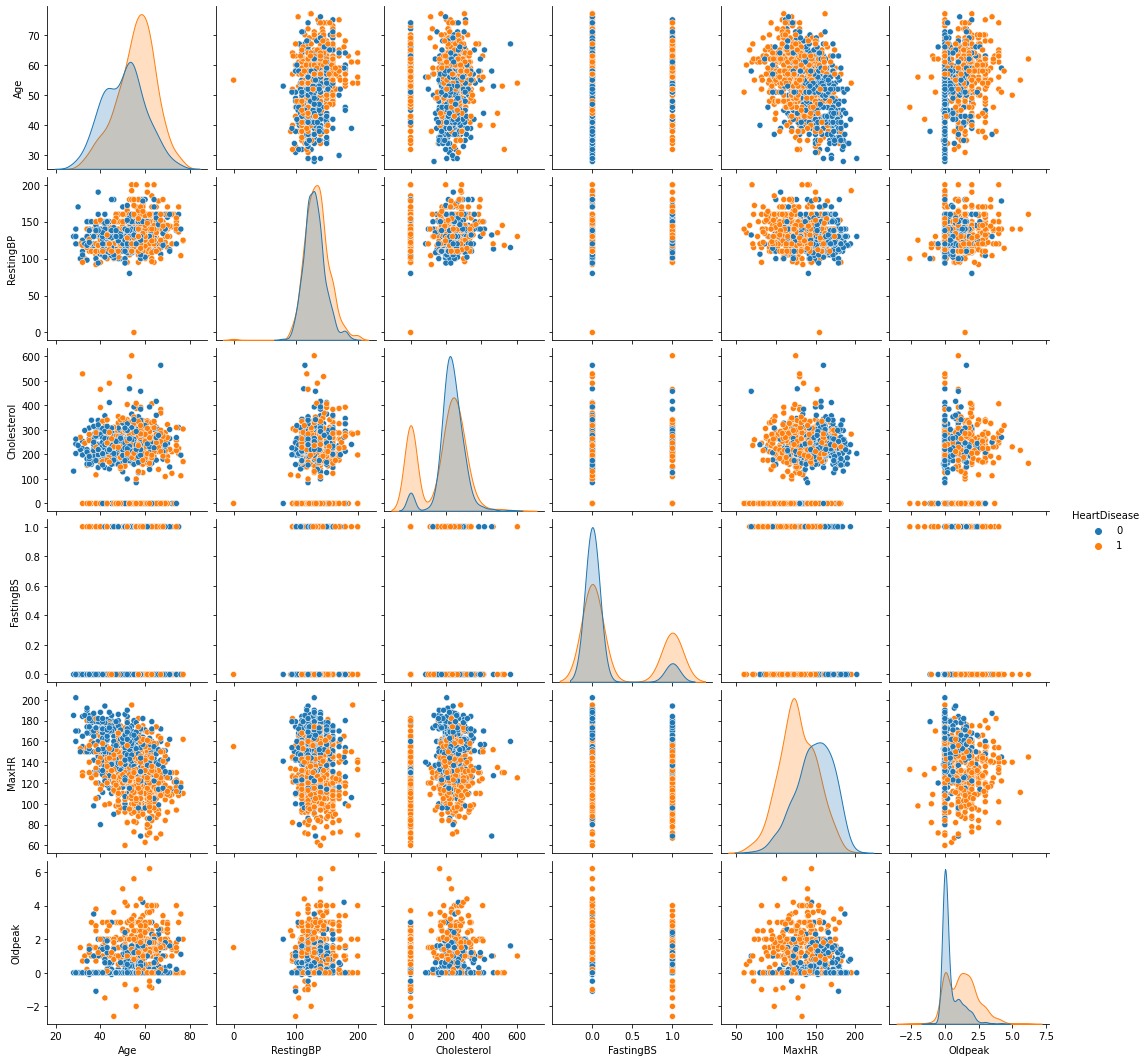

In [3]:
sns.pairplot(df,hue="HeartDisease")

In [4]:
df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


In [6]:
df['HeartDisease'].value_counts()

1    508
0    410
Name: HeartDisease, dtype: int64

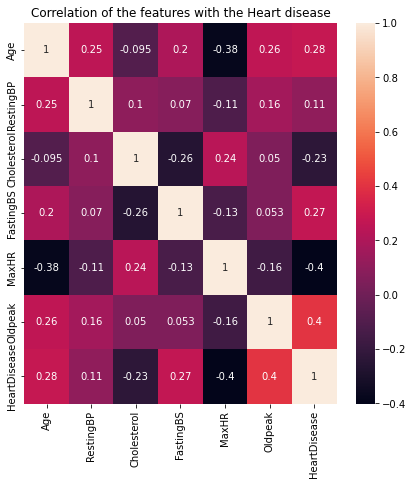

In [7]:
cor = df.corr()
plt.figure(figsize=(7,7))
sns.heatmap(cor, annot=True);
plt.title('Correlation of the features with the Heart disease');

# Feature engineering

In [8]:
def feature_processing(data, numeric_cols, categorical_cols, target_col, skew_limit = 0.75):
    data_num = data[numeric_cols].apply(pd.to_numeric, errors = ('coerce'))
    skew_vals = data_num.skew()
    skew_cols = (skew_vals.sort_values(ascending = False).to_frame().rename(columns = {0:'Skew'}).query('abs(Skew) > {}'.format(skew_limit)))
    for col in skew_cols.index.values:
        data_num[col] = data_num[col].apply(np.log1p)
    
    data_num.fillna(data_num.mean(), inplace = True)
    data_num = data_num.replace([np.inf, -np.inf],0)
    
    other_num_cols = [x for x in numeric_cols if x not in skew_cols]
    
    scaler = StandardScaler()
    scaler.fit(data_num[other_num_cols])
    data_num[other_num_cols] = scaler.transform(data_num[other_num_cols])
        
    
    print("Features that had skew are:", skew_cols)
    
    data_cat = data[categorical_cols]
    data_cat = data_cat.apply(LabelEncoder().fit_transform)
    data_transformed = pd.concat([data_num, data_cat], axis = 1)
    data_transformed[target_col] = data[target_col]
    
    return data_transformed

In [9]:
target_col = ['HeartDisease']
all_features = [x for x in df.columns if x not in target_col]
numeric_cols = ['Age','RestingBP','Cholesterol','FastingBS','MaxHR','Oldpeak']
categorical_cols = [x for x in all_features if x not in numeric_cols]

data_transformed = feature_processing(df, numeric_cols = numeric_cols, categorical_cols = categorical_cols,
                                      target_col = target_col )

Features that had skew are:                Skew
FastingBS  1.264484
Oldpeak    1.022872


In [10]:
data_transformed

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,Sex,ChestPainType,RestingECG,ExerciseAngina,ST_Slope,HeartDisease
0,-1.433140,0.410909,0.825070,-0.551341,1.382928,-0.946215,1,1,1,0,2,0
1,-0.478484,1.491752,-0.171961,-0.551341,0.754157,0.366358,0,2,1,0,1,1
2,-1.751359,-0.129513,0.770188,-0.551341,-1.525138,-0.946215,1,1,2,0,2,0
3,-0.584556,0.302825,0.139040,-0.551341,-1.132156,0.788912,0,0,1,1,1,1
4,0.051881,0.951331,-0.034755,-0.551341,-0.581981,-0.946215,1,2,1,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,-0.902775,-1.210356,0.596393,-0.551341,-0.188999,0.546842,1,3,1,0,1,1
914,1.536902,0.627078,-0.053049,1.813758,0.164684,1.859415,1,0,1,0,1,1
915,0.370100,-0.129513,-0.620168,-0.551341,-0.857069,0.546842,1,0,1,1,1,1
916,0.370100,-0.129513,0.340275,-0.551341,1.461525,-0.946215,0,1,0,0,1,1


# Applying ML models

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data_transformed[numeric_cols + categorical_cols],
                                                    data_transformed['HeartDisease'], test_size = 0.2, 
                                                    random_state = 2890)

In [12]:
print("X_train shape:", X_train.shape, "X_test shape:", X_test.shape,"y_train shape:", y_train.shape,"y_test shape:", y_test.shape)

X_train shape: (734, 11) X_test shape: (184, 11) y_train shape: (734,) y_test shape: (184,)


In [13]:
y_train.value_counts(normalize = True)

1    0.566757
0    0.433243
Name: HeartDisease, dtype: float64

In [14]:
y_test.value_counts(normalize = True)

0    0.5
1    0.5
Name: HeartDisease, dtype: float64

In [15]:
lr = LogisticRegression(solver='liblinear').fit(X_train, y_train)
lr_l1 = LogisticRegressionCV(Cs=10, cv=4, penalty='l1', solver='liblinear').fit(X_train, y_train)
lr_l2 = LogisticRegressionCV(Cs=10, cv=4, penalty='l2', solver='liblinear').fit(X_train, y_train)

y_pred_lr = list()
y_prob_lr = list()

coeff_labels_lr = ['lr', 'l1', 'l2']
coeff_models_lr = [lr, lr_l1, lr_l2]

for lab,mod in zip(coeff_labels_lr, coeff_models_lr):
    y_pred_lr.append(pd.Series(mod.predict(X_test), name=lab))
    y_prob_lr.append(pd.Series(mod.predict_proba(X_test).max(axis=1), name=lab))
    
y_pred_lr = pd.concat(y_pred_lr, axis=1)
y_prob_lr = pd.concat(y_prob_lr, axis=1)

y_pred_lr.head()

,lr,l1,l2
0,0,0,0
1,0,0,0
2,1,1,1
3,0,0,0
4,0,0,0


In [16]:
metrics = list()
cm = dict()

for lab in coeff_labels_lr:

    # Preciision, recall, f-score from the multi-class support function
    precision, recall, fscore, _ = score(y_test, y_pred_lr[lab], average='weighted')
    
    # The usual way to calculate accuracy
    accuracy = accuracy_score(y_test, y_pred_lr[lab])
    
    # ROC-AUC scores can be calculated by binarizing the data
    auc = roc_auc_score(label_binarize(y_test, classes=[0,1]),
              label_binarize(y_pred_lr[lab], classes=[0,1]), 
              average='weighted')
    
    # Last, the confusion matrix
    cm[lab] = confusion_matrix(y_test, y_pred_lr[lab])
    
    metrics.append(pd.Series({'precision':precision, 'recall':recall, 
                              'fscore':fscore, 'accuracy':accuracy,
                              'auc':auc}, 
                             name=lab))
metrics = pd.concat(metrics, axis=1)

In [17]:
metrics

,lr,l1,l2
precision,0.820690,0.810112,0.815366
recall,0.820652,0.809783,0.815217
fscore,0.820647,0.809732,0.815196
accuracy,0.820652,0.809783,0.815217
auc,0.820652,0.809783,0.815217


In [18]:
max_k = 40
f1_scores = list()
error_rates = list() # 1-accuracy

for k in range(1, max_k):
    
    knn = KNeighborsClassifier(n_neighbors=k, weights='distance')
    knn = knn.fit(X_train, y_train)
    
    y_pred_knn = knn.predict(X_test)
    f1 = f1_score(y_pred_knn, y_test)
    f1_scores.append((k, round(f1_score(y_test, y_pred_knn), 4)))
    error = 1-round(accuracy_score(y_test, y_pred_knn), 4)
    error_rates.append((k, error))
    
f1_results = pd.DataFrame(f1_scores, columns=['K', 'F1 Score'])
error_results = pd.DataFrame(error_rates, columns=['K', 'Error Rate'])

<Figure size 1800x1200 with 0 Axes>

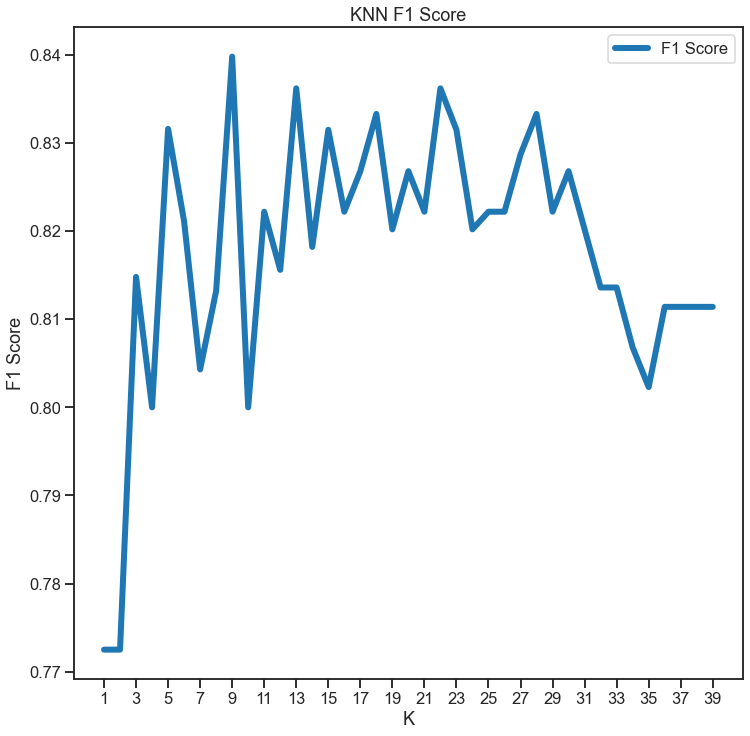

In [19]:
# Plot F1 results
sns.set_context('talk')
sns.set_style('ticks')

plt.figure(dpi=300)
ax = f1_results.set_index('K').plot( figsize=(12, 12), linewidth=6)
ax.set(xlabel='K', ylabel='F1 Score')
ax.set_xticks(range(1, max_k, 2));
plt.title('KNN F1 Score')
plt.savefig('knn_f1.png')

<Figure size 1800x1200 with 0 Axes>

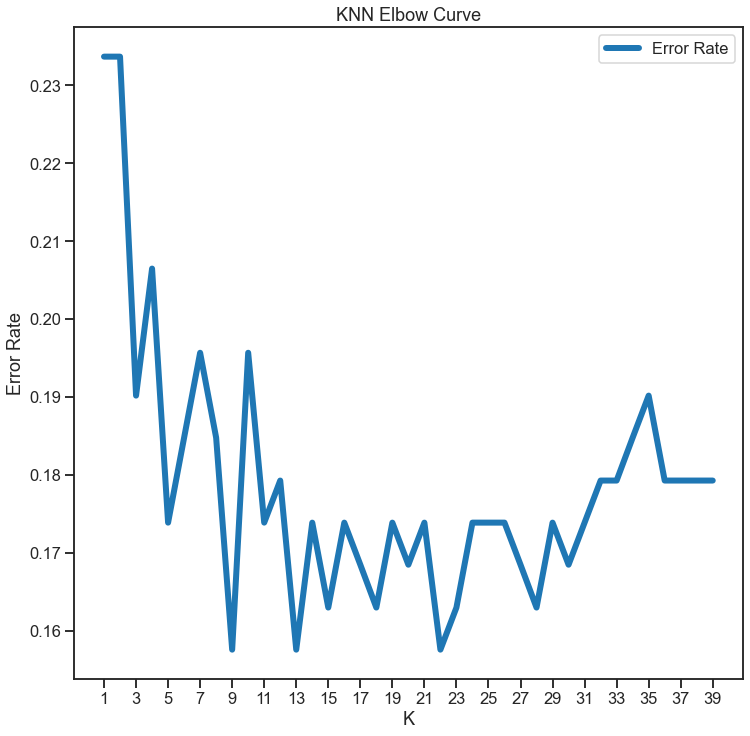

In [20]:
sns.set_context('talk')
sns.set_style('ticks')

plt.figure(dpi=300)
ax = error_results.set_index('K').plot( figsize=(12, 12), linewidth=6)
ax.set(xlabel='K', ylabel='Error Rate')
ax.set_xticks(range(1, max_k, 2))
plt.title('KNN Elbow Curve')
plt.savefig('knn_elbow.png')

In [21]:
knn = KNeighborsClassifier(n_neighbors=22, weights='distance')
knn = knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

In [22]:
# Initialize the random forest estimator
# Note that the number of trees is not setup here
RF = RandomForestClassifier(oob_score=True, 
                            random_state=42, 
                            warm_start=True,
                            n_jobs=-1)

oob_list = list()

# Iterate through all of the possibilities for 
# number of trees
for n_trees in [15, 20, 30, 40, 50, 100, 150, 200, 300, 400]:
    
    # Use this to set the number of trees
    RF.set_params(n_estimators=n_trees)

    # Fit the model
    RF.fit(X_train, y_train)

    # Get the oob error
    oob_error = 1 - RF.oob_score_
    
    # Store it
    oob_list.append(pd.Series({'n_trees': n_trees, 'oob': oob_error}))

rf_oob_df = pd.concat(oob_list, axis=1).T.set_index('n_trees')

rf_oob_df

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:541: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:545: RuntimeWarning: invalid value encountered in true_divide
  decision = (predictions[k] /


,oob
n_trees,
15.0,0.145777
20.0,0.155313
30.0,0.148501
40.0,0.140327
50.0,0.140327
100.0,0.129428
150.0,0.132153
200.0,0.123978
300.0,0.129428


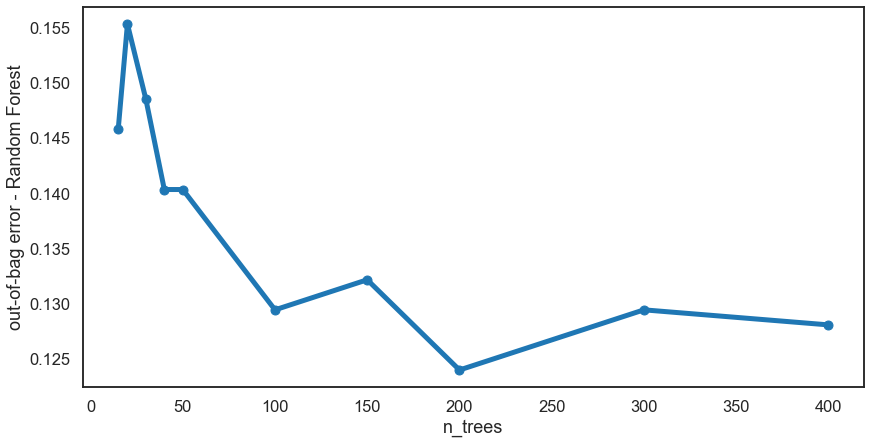

In [23]:
sns.set_context('talk')
sns.set_style('white')

ax = rf_oob_df.plot(legend=False, marker='o', figsize=(14, 7), linewidth=5)
ax.set(ylabel='out-of-bag error - Random Forest');

In [24]:
# Random forest with 100 estimators
rf = RF.set_params(n_estimators=200)
y_pred_rf = rf.predict(X_test)

In [25]:
### BEGIN SOLUTION
error_list = list()

# Iterate through various possibilities for number of trees
tree_list = [2,5,7,15, 25, 50, 60, 75, 85, 100]
for n_trees in tree_list:
    
    # Initialize the gradient boost classifier
    GBC = GradientBoostingClassifier(n_estimators=n_trees, random_state=42)

    # Fit the model
    print(f'Fitting model with {n_trees} trees')
    GBC.fit(X_train.values, y_train.values)
    y_pred_gb = GBC.predict(X_test)

    # Get the error
    error = 1.0 - accuracy_score(y_test, y_pred_gb)
    
    # Store it
    error_list.append(pd.Series({'n_trees': n_trees, 'error': error}))

error_df_gb = pd.concat(error_list, axis=1).T.set_index('n_trees')

error_df_gb

Fitting model with 2 trees
Fitting model with 5 trees
Fitting model with 7 trees
Fitting model with 15 trees
Fitting model with 25 trees
Fitting model with 50 trees
Fitting model with 60 trees
Fitting model with 75 trees
Fitting model with 85 trees
Fitting model with 100 trees


,error
n_trees,
2.0,0.244565
5.0,0.135870
7.0,0.135870
15.0,0.141304
25.0,0.141304
50.0,0.135870
60.0,0.135870
75.0,0.141304
85.0,0.141304


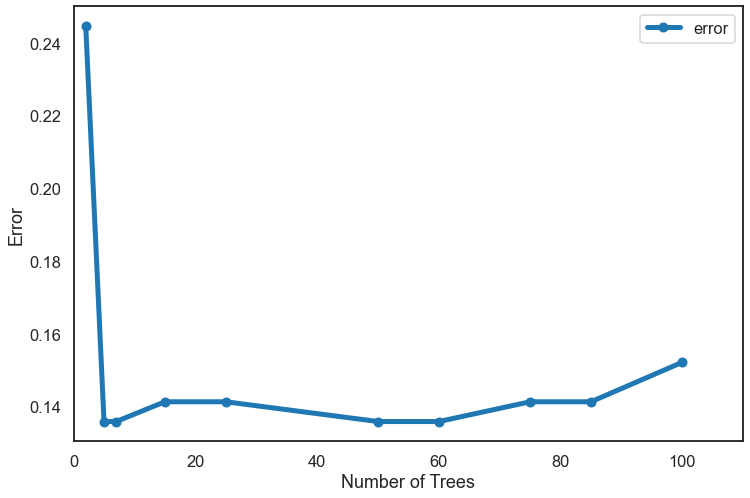

In [26]:
sns.set_context('talk')
sns.set_style('white')

ax = error_df_gb.plot(marker='o', figsize=(12, 8), linewidth=5)
ax.set(xlabel='Number of Trees', ylabel='Error')
ax.set_xlim(0, max(error_df_gb.index)*1.1);

In [27]:
# The parameters to be fit
param_grid = {'n_estimators': tree_list,
              'learning_rate': [0.1, 0.01, 0.001, 0.0001],
              'subsample': [1.0, 0.5],
              'max_features': [1, 2, 3, 4]}

# The grid search object
GV_GBC = GridSearchCV(GradientBoostingClassifier(random_state=42), 
                      param_grid=param_grid, 
                      scoring='accuracy',
                      n_jobs=-1)

# Do the grid search
GV_GBC = GV_GBC.fit(X_train, y_train)

In [28]:
# The best model
gb_model = GV_GBC.best_estimator_
y_pred_gb = GV_GBC.predict(X_test)
gb_model

GradientBoostingClassifier(max_features=3, n_estimators=85, random_state=42)

In [ ]:
## ENSEMBLE: STACKING OF LR, KNN, RANDOM FOREST AND GRADIENT BOOSTING

In [29]:
estimators = [
    ('KNN', knn),
    ('Random_forest', rf),
    ('Gradient_boosting', GV_GBC )
]

model_stack = StackingClassifier(estimators = estimators, final_estimator = lr)
model_stack.fit(X_train, y_train)
y_label_stack = model_stack.predict(X_test)
y_proba_stack = model_stack.predict_proba(X_test)

In [30]:
#Logistics Regression
print(classification_report(lr.predict(X_test), y_test))

              precision    recall  f1-score   support

           0       0.83      0.82      0.82        93
           1       0.82      0.82      0.82        91

    accuracy                           0.82       184
   macro avg       0.82      0.82      0.82       184
weighted avg       0.82      0.82      0.82       184



In [31]:
#KNN
print(classification_report(knn.predict(X_test), y_test))

              precision    recall  f1-score   support

           0       0.88      0.82      0.85        99
           1       0.80      0.87      0.84        85

    accuracy                           0.84       184
   macro avg       0.84      0.84      0.84       184
weighted avg       0.85      0.84      0.84       184



In [32]:
#Random Forest
print(classification_report(rf.predict(X_test), y_test))

              precision    recall  f1-score   support

           0       0.82      0.88      0.85        85
           1       0.89      0.83      0.86        99

    accuracy                           0.85       184
   macro avg       0.85      0.86      0.85       184
weighted avg       0.86      0.85      0.85       184



In [33]:
#GB
print(classification_report(GV_GBC.predict(X_test), y_test))

              precision    recall  f1-score   support

           0       0.85      0.85      0.85        92
           1       0.85      0.85      0.85        92

    accuracy                           0.85       184
   macro avg       0.85      0.85      0.85       184
weighted avg       0.85      0.85      0.85       184



In [34]:
#Stack
print(classification_report(model_stack.predict(X_test), y_test))

              precision    recall  f1-score   support

           0       0.84      0.87      0.85        89
           1       0.87      0.84      0.86        95

    accuracy                           0.85       184
   macro avg       0.85      0.85      0.85       184
weighted avg       0.85      0.85      0.85       184



In [35]:
models_accuracy_scores = {}
models_accuracy_scores["Logistic Regression"] = [f1_score(y_test,lr.predict(X_test),average="weighted"),
                                                 lr.score(X_test,y_test),
                                                 recall_score(y_test,lr.predict(X_test), average = 'binary')]
models_accuracy_scores["K-Nearest Neighbors"] = [f1_score(y_test,knn.predict(X_test),average="weighted"),
                                                 knn.score(X_test,y_test),
                                                 recall_score(y_test,knn.predict(X_test), average = 'binary')]
models_accuracy_scores["Random Forest"] = [f1_score(y_test,rf.predict(X_test),average="weighted"),
                                                 rf.score(X_test,y_test),
                                                 recall_score(y_test,rf.predict(X_test), average = 'binary')]
models_accuracy_scores["Gradient Boosting"] = [f1_score(y_test,GV_GBC.predict(X_test),average="weighted"),
                                                 GV_GBC.score(X_test,y_test),
                                                 recall_score(y_test,GV_GBC.predict(X_test), average = 'binary')]
models_accuracy_scores["Stacking"] = [f1_score(y_test,model_stack.predict(X_test),average="weighted"),
                                                 model_stack.score(X_test,y_test),
                                                 recall_score(y_test,model_stack.predict(X_test), average = 'binary')]

In [36]:
models_accuracy_scores

{'Logistic Regression': [0.8206468763845812,
  0.8206521739130435,
  0.8152173913043478],
 'K-Nearest Neighbors': [0.8421628656787056,
  0.842391304347826,
  0.8043478260869565],
 'Random Forest': [0.8530481852870706, 0.8532608695652174, 0.8913043478260869],
 'Gradient Boosting': [0.8478260869565218,
  0.8478260869565217,
  0.8478260869565217],
 'Stacking': [0.8532218512719001, 0.8532608695652174, 0.8695652173913043]}

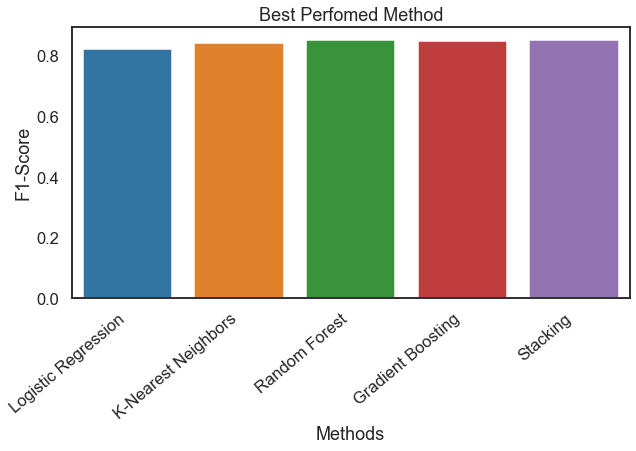

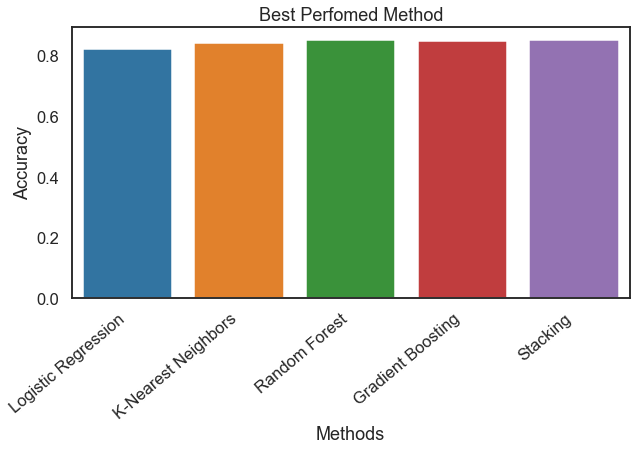

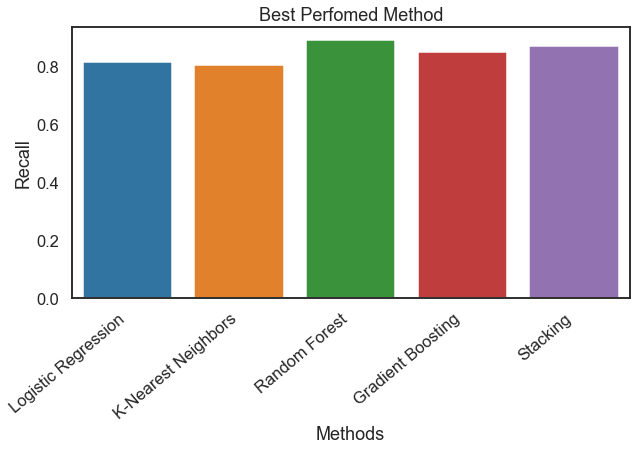

In [37]:
names = ["F1-Score","Accuracy","Recall"]
df_scores = pd.DataFrame(models_accuracy_scores.values(),columns = names,index=models_accuracy_scores.keys())
    
for names in df_scores.columns:
    fig = plt.figure(figsize = (10, 5))
    ax = sns.barplot(y=df_scores[names],x=df_scores.index)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right") 
    plt.xlabel("Methods")
    plt.ylabel(names)
    plt.title("Best Perfomed Method")
    plt.show()

In [38]:
df_scores

,F1-Score,Accuracy,Recall
Logistic Regression,0.820647,0.820652,0.815217
K-Nearest Neighbors,0.842163,0.842391,0.804348
Random Forest,0.853048,0.853261,0.891304
Gradient Boosting,0.847826,0.847826,0.847826
Stacking,0.853222,0.853261,0.869565
